In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45743")
client

<Client: 'tcp://127.0.0.1:45743' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:45743' processes=2 threads=16, memory=58.99 GiB>

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [6]:
from validate_catalog import all_params
params_dict, cat = all_params()

fio01grid = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/grid.zarr"))

In [12]:
fio01w = cat["FIO-COM32"](region='1',datatype='interior_daily', season='fma').to_dask().chunk({'st_ocean':5, 'sw_ocean':5})
fio01w

<xarray.Dataset>
Dimensions:        (bnds: 2, st_ocean: 57, sw_ocean: 57, time: 89, xt_ocean: 320, xu_ocean: 321, yt_ocean: 320, yu_ocean: 321)
Coordinates:
  * st_ocean       (st_ocean) float64 1.0 3.196 5.96 ... 6.117e+03 6.684e+03
  * sw_ocean       (sw_ocean) float64 2.098 4.578 7.784 ... 6.4e+03 7e+03
  * time           (time) datetime64[ns] 2018-02-02T12:00:00 ... 2018-04-30T1...
  * xt_ocean       (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.05 -68.02
  * xu_ocean       (xu_ocean) float64 -78.0 -77.97 -77.94 ... -68.03 -68.0
  * yt_ocean       (yt_ocean) float64 30.02 30.05 30.08 ... 39.92 39.95 39.98
  * yu_ocean       (yu_ocean) float64 30.0 30.03 30.06 ... 39.94 39.97 40.0
Dimensions without coordinates: bnds
Data variables:
    salt           (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 5, 320, 320), meta=np.ndarray>
    st_ocean_bnds  (st_ocean, bnds) float64 dask.array<chunksize=(5, 2), meta=np.ndarray>
    sw_ocean_bnds  (sw_ocean, bnds) float64 dask.array<chunksize=(5, 2), meta=np.ndarray>
    temp           (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 5, 320, 320), meta=np.ndarray>
    u              (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(5, 5, 321, 321), meta=np.ndarray>
    v              (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(5, 5, 321, 321), meta=np.ndarray>
    wt             (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 5, 320, 320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [36]:
dz = xr.DataArray(np.diff(fio01w.st_ocean.data), dims=['sw_ocean'],
                  coords=fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)).coords
                 )
dz

<xarray.DataArray (sw_ocean: 56)>
array([  2.19577393,   2.76393202,   3.64885899,   4.76393202,
         6.        ,   7.23606798,   8.35114101,   9.23606798,
         9.80422607,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  11.12281967,  14.47715857,
        20.02083395,  27.68413087,  37.37067893,  48.95866416,
        62.30236092,  77.23396449,  93.56570129, 111.09219025,
       129.59302561, 148.83554862, 168.57777339, 188.57143   ,
       208.56508661, 228.30731138, 247.54983439, 266.05066975,
       283.57715871, 299.90889551, 314.84049908, 328.18419584,
       339.77218107, 349.45872913, 357.12202605, 362.66570143,
       366.02004033, 367.14286   , 433.57143   , 566.42857   ])
Coordinates:
  * sw_ocean  (sw_ocean) float64 2.098 4.578 7.784 ... 5.5e+03 5.9e+03 6.4e+03

In [14]:
grav = 9.81
w_path = f'{SCRATCH}/region01/FIO-COM32/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0.chunk({'st_ocean':5})

b_win = -xr.DataArray(sig0w.data, dims=fio01w.temp.dims, coords=fio01w.temp.coords) * grav / 1e3

b_win

,Array,Chunk
Bytes,3.87 GiB,1.91 MiB
Shape,"(89, 57, 320, 320)","(5, 5, 100, 100)"
Count,17569 Tasks,3456 Chunks
Type,float64,numpy.ndarray


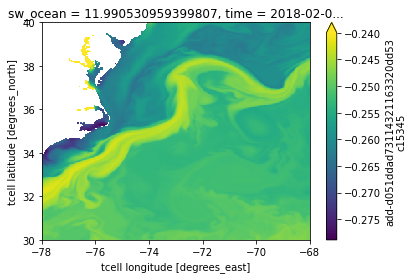

In [15]:
bw = .5*xr.DataArray(b_win.isel(st_ocean=slice(None,-1)).data + b_win.isel(st_ocean=slice(1,None)).data,
                     dims=['time','sw_ocean','yt_ocean','xt_ocean'],
                     coords=fio01w.wt.isel(sw_ocean=slice(None,-1)).coords
                    )
bw.isel(time=0,sw_ocean=3).plot(vmax=-.24)

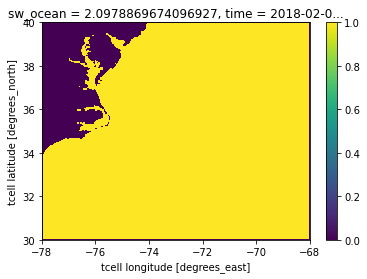

In [28]:
maskb = np.ma.masked_invalid(bw.isel(time=0)).mask
mask = ~np.ma.masked_array(np.ma.masked_invalid(fio01w.wt.isel(time=0,sw_ocean=slice(None,-1))),maskb).mask

wet_mask = xr.DataArray(np.zeros_like(fio01w.wt.isel(time=0,sw_ocean=slice(None,-1))),
                        dims=['sw_ocean','yt_ocean','xt_ocean'],
                        coords=fio01w.wt.isel(time=0,sw_ocean=slice(None,-1)).coords
           )
wet_mask[:,1:-1,1:-1] = mask[:,1:-1,1:-1].astype(np.float64)
wet_mask.isel(sw_ocean=0).plot()

In [14]:
z10 = 3   # grid index of ~10m depth
nMLDw = z10 + np.abs((sig0w.isel(st_ocean=slice(z10,None)).fillna(0.)
                      - sig0w.isel(st_ocean=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='st_ocean').compute()  # indexing needs loading
MLDw = (xr.ones_like(sig0w) 
        * fio01w.st_ocean).reset_coords(drop=True)[{'st_ocean':nMLDw}] 


In [15]:
tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/MLD_fma.zarr


In [108]:
nMLDs = z10 + np.abs((sig0s.isel(depth=slice(z10,None)).fillna(0.)
                      - sig0s.isel(depth=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='depth').compute()  # indexing needs loading
MLDs = (xr.ones_like(sig0s) 
        * fesom01w.depth).reset_coords(drop=True)[{'depth':nMLDs}]  
# del nMLDs
MLDs

<xarray.DataArray (time_counter: 89, y: 763, x: 611)>
dask.array<reshape, shape=(89, 763, 611), dtype=float64, chunksize=(89, 763, 611), chunktype=numpy.ndarray>
Coordinates:
    deptht        (time_counter, y, x) float64 115.2 109.0 103.1 ... 70.72 70.72
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x

In [139]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr


In [17]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/MLD_fma.zarr")
                   ).MLD.chunk({'time':10,'yt_ocean':100,'xt_ocean':100})

MLDw

<xarray.DataArray 'MLD' (time: 89, yt_ocean: 320, xt_ocean: 320)>
dask.array<rechunk-merge, shape=(89, 320, 320), dtype=float64, chunksize=(10, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-02-02T12:00:00 ... 2018-04-30T12:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [18]:
area = xr.DataArray(fio01grid.DXT * fio01grid.DYT, dims=['yt_ocean','xt_ocean'],
                    coords=fio01w.temp.isel(time=0,st_ocean=0).coords)

area

<xarray.DataArray (yt_ocean: 320, xt_ocean: 320)>
array([[10455198., 10455198., 10455198., ..., 10455198., 10455198.,
        10455198.],
       [10451902., 10451902., 10451902., ..., 10451902., 10451902.,
        10451902.],
       [10448603., 10448603., 10448603., ..., 10448603., 10448603.,
        10448603.],
       ...,
       [ 9260196.,  9260196.,  9260196., ...,  9260196.,  9260196.,
         9260196.],
       [ 9255968.,  9255968.,  9255968., ...,  9255968.,  9255968.,
         9255968.],
       [ 9251738.,  9251738.,  9251738., ...,  9251738.,  9251738.,
         9251738.]], dtype=float32)
Coordinates:
    st_ocean  float64 1.0
    time      datetime64[ns] 2018-02-02T12:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [46]:
dxw = xr.DataArray(.5*(fio01grid.DXC[1:,:-1].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(.5*(fio01grid.DYC[1:,:-1].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(.5*(fio01grid.DXC[:-1,1:].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(.5*(fio01grid.DYC[:-1,1:].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'mul-125fe32bed295ab171aa252f35d51da3' (yt_ocean: 320, xt_ocean: 320)>
dask.array<mul, shape=(320, 320), dtype=float32, chunksize=(160, 320), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 1.0
    time      datetime64[ns] 2018-02-02T12:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [47]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(2663.1006, dtype=float32)

In [21]:
kappa_w = xr.ones_like(wet_mask)

kappa_s = xr.ones_like(wet_mask)

In [48]:
filter_scale = 30000.
filt_mask = wet_mask.chunk({'yt_ocean':-1,'xt_ocean':-1}).reset_coords(drop=True)

filter_30km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dyw': dyw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
            'dxs': dxs.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dys': dys.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
            'area': area.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
            'kappa_w': kappa_w.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
            'kappa_s': kappa_s.chunk({'yt_ocean':-1,'xt_ocean':-1})
        }
    )

In [58]:
ww_filtered_to_30km = filter_30km.apply(fio01w.wt.isel(sw_ocean=slice(None,-1)).chunk({'yt_ocean':-1,'xt_ocean':-1}), 
                                        dims=['yt_ocean','xt_ocean'])
ww_filtered_to_30km

,Array,Chunk
Bytes,1.90 GiB,9.77 MiB
Shape,"(89, 56, 320, 320)","(5, 5, 320, 320)"
Count,1428 Tasks,216 Chunks
Type,float32,numpy.ndarray


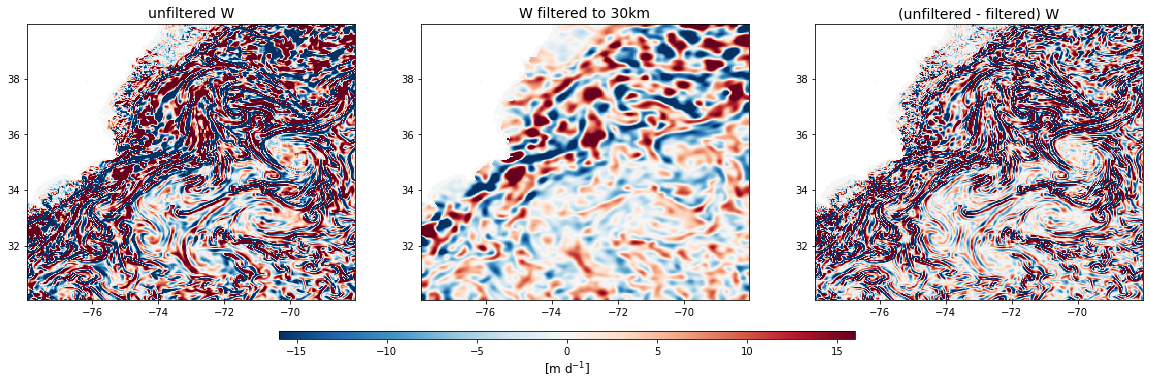

In [50]:
vmin = -16
vmax = 16

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                       fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                       (fio01w.wt*86400).isel(time=0, sw_ocean=5,
                                              yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'},
                       shading='auto', rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=14)

axs[1].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                  fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                  (ww_filtered_to_30km.isel(time=0, sw_ocean=5,
                                            yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)
                                           )*86400), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[1].set_title('W filtered to 30km', fontsize=14)

axs[2].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                  fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                  ((fio01w.wt.isel(time=0,sw_ocean=5) 
                    - ww_filtered_to_30km.isel(time=0,sw_ocean=5)
                   )*86400).isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)), 
                  vmax=vmax, vmin=vmin,
                  cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) W', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.3, 0.15, 0.4, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/FIOCOM01_wp_Feb-01.pdf')

In [55]:
bw_filtered_to_30km = filter_30km.apply(bw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
                                        dims=['yt_ocean','xt_ocean'])

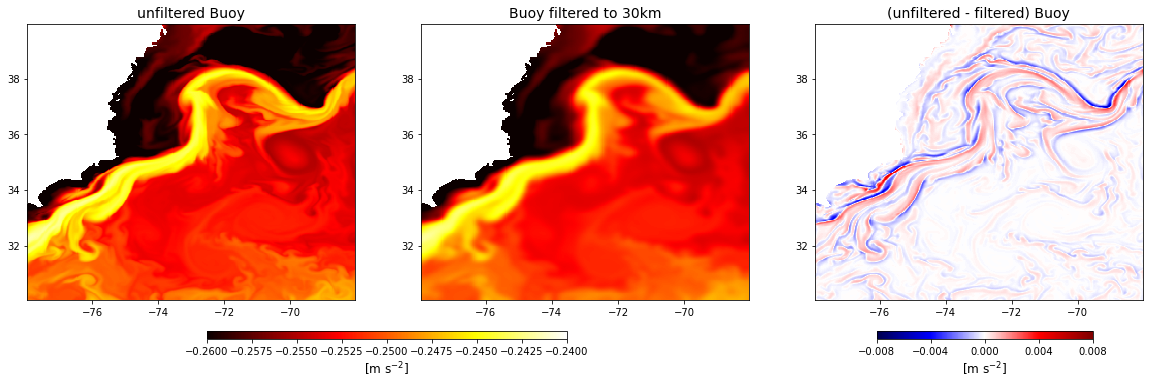

In [56]:
vmin = -.26
vmax = -.24

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                       fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                       bw.isel(time=0,sw_ocean=5,yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='hot', 
                       shading='auto', rasterized=True
)
axs[0].set_title(r'unfiltered Buoy', fontsize=14)

axs[1].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                  fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                  bw_filtered_to_30km.isel(time=0,sw_ocean=5,
                                           yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)), 
                  vmin=vmin, vmax=vmax, 
                  cmap='hot', 
                  shading='auto', rasterized=True
)
axs[1].set_title(r'Buoy filtered to 30km', fontsize=14)

im2 = axs[2].pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                        fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                        (bw.isel(time=0,sw_ocean=5) 
                         - bw_filtered_to_30km.isel(time=0,sw_ocean=5)
                        ).isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)), 
                        vmax=.008, vmin=-.008,
                        cmap='seismic', 
                        shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) Buoy', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.25, 0.15, 0.25, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)
cbaxes = fig.add_axes([0.715, 0.15, 0.15, 0.018]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.008,-.004,0.,.004,.008]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/FIOCOM01_bp_Feb-01.pdf')

In [59]:
wpbpw = ((((fio01w.wt.isel(sw_ocean=slice(None,-1),yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)) 
            - ww_filtered_to_30km
           ) * (bw.isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1)) 
                - bw_filtered_to_30km
               )
          ).where(wet_mask.isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1))!=0.)
          * dz
         ).where(fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)) <= MLDw.isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1))
                ).sum('sw_ocean',skipna=True) 
         / MLDw.isel(yt_ocean=slice(1,-1),xt_ocean=slice(1,-1))
        ).chunk({'yt_ocean':100,'xt_ocean':100})
wpbpw

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

<xarray.DataArray (time: 89, yt_ocean: 318, xt_ocean: 318)>
dask.array<rechunk-merge, shape=(89, 318, 318), dtype=float64, chunksize=(5, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 30.05 30.08 30.11 30.14 ... 39.89 39.92 39.95
  * xt_ocean  (xt_ocean) float64 -77.95 -77.92 -77.89 ... -68.11 -68.08 -68.05
  * time      (time) datetime64[ns] 2018-02-02T12:00:00 ... 2018-04-30T12:00:00
    st_ocean  float64 1.0

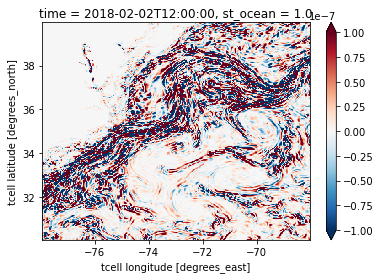

In [54]:
wpbpw.isel(time=0).plot(vmax=1e-7)

In [60]:
tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/wb-30km_z0-MLD_fma.zarr


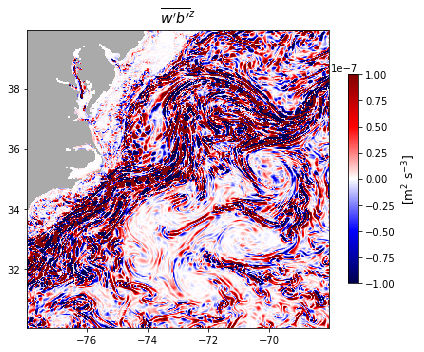

In [61]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/wb-30km_z0-MLD_fma.zarr")).wpbp

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
                   fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
                   wpbpw.isel(time=0).where(wet_mask.isel(sw_ocean=0,yt_ocean=slice(1,-1),xt_ocean=slice(1,-1))!=0.),
                   vmin=-1e-7, vmax=1e-7,
                   cmap='seismic', shading='auto', rasterized=True
)
ax.pcolormesh(fio01w.xt_ocean.isel(xt_ocean=slice(1,-1)), 
              fio01w.yt_ocean.isel(yt_ocean=slice(1,-1)),
              np.ma.masked_invalid(wet_mask.where(wet_mask!=1).isel(sw_ocean=0,yt_ocean=slice(1,-1),xt_ocean=slice(1,-1))),
              vmin=-1, vmax=2,
              cmap='binary', shading='auto', rasterized=True)

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FIOCOM01_wpbpz_Feb-01.pdf')